# 6) Model selection

Experimenting with various models shows that a Random Forest model trained on TF-IDF vectors looks to be the most promising. Interestingly, neural networks trained on vector embeddings perform very poorly. The small size of the dataset and large gap between training and validation accuracy suggest that these comparatively more complex models are overfitting.

## Read-in data

Seperate dataframes are read-in for each language and dataset type. 

In [1]:
import pandas as pd
import numpy as np

# reads in the spanish improved label headlines
spanish_improved_labels_df = pd.read_csv('../Data/spanish_improved_labels_df.csv', encoding='utf-8').reset_index(drop=True)
print(str(round(len(spanish_improved_labels_df)/1000, 1)) + 'K Spanish train headlines')

# reads in the spanish put aside headlines
spanish_put_aside_df = pd.read_csv('../Data/spanish_put_aside_df.csv', encoding='utf-8').reset_index(drop=True)
print(str(round(len(spanish_put_aside_df)/1000, 1)) + 'K Spanish put aside headlines')

# reads in the portuguese improved label headlines
portuguese_improved_labels_df = pd.read_csv('../Data/portuguese_improved_labels_df.csv', encoding='utf-8').reset_index(drop=True)
print(str(round(len(portuguese_improved_labels_df)/1000, 1)) + 'K Portuguese train headlines')

# reads in the portuguese put aside headlines
portuguese_put_aside_df = pd.read_csv('../Data/portuguese_put_aside_df.csv', encoding='utf-8').reset_index(drop=True)
print(str(round(len(portuguese_put_aside_df)/1000, 1)) + 'K Portuguese put aside headlines')

24.2K Spanish train headlines
0.6K Spanish put aside headlines
6.6K Portuguese train headlines
0.6K Portuguese put aside headlines


## Create risk type dataframe

Creates a dataframe with all the headlines from a certain risk type and an equal number of other headlines. These other headlines include both non-risk type headlines and other risk types, helping the model to learn better by distinguishing between specific risk types.

In [2]:
import random

# returns a dataframe containing all of a specific risk type and and equal number 
# of randomly sampled other and non risks
def risk_type_df(df, risk_type):
    # a specified risk type 
    risk_type_df = df.loc[df.risk_type==risk_type]

    # ranodmly sampled non risks
    population, sample_no = list(df.loc[~df.index.isin(risk_type_df.index)].index), len(risk_type_df)
    non_risks = random.sample(population, sample_no)
    non_risks_df = df.loc[df.index.isin(non_risks)]

    # concatenates risks and non-risks
    risk_type_df = pd.concat([risk_type_df, non_risks_df])

    # creates a binary coolumn to indicate whether a risk is the specified risk type or not
    risk_type_df['y_value'] = [1 if x == risk_type else 0 for x in risk_type_df['risk_type']]
    
    return risk_type_df

## Training functions

### Train test split

Creates a train test split for a given dataframe.

In [3]:
from sklearn.model_selection import train_test_split

# returns a train test split
def split_data(df, risk_type, test_size=0.25):
    # defines X
    X = df.headline
    
    # defines y
    if risk_type != None:
        y = df.y_value
    else:
        y = [int(pd.notna(x)) for x in df.risk_type]
        
    # returns a split
    return train_test_split(X, y, test_size=test_size, stratify=y)

### TF-IDF

A model is fit and evaluated on TF-IDF vectors.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# evaluates a model by printing the accuracy and classification report
def evaluate_model(model, X_test_tfidf, y_test):
    # generates predictions
    y_pred = model.predict(X_test_tfidf)
    print("Accuracy:", round(accuracy_score(y_test, y_pred), 2))
    print()
    
    # prints classification report
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print()
    return classification_report(y_test, y_pred, output_dict=True)

# evaluates a filtered dataset against new headlines using tf-idf vectors and logistic regression 
def fit_evaluate_tfidf(model, train_df, put_aside_df, risk_type, language):
    # prints the language
    print()
    print('*** ' + language + ': ' + str(risk_type) + ' ***')
    print()

    # reassigns the train df to focus on a particular risk type and defines the y_test variable
    if risk_type != None:
        train_df, y_test = risk_type_df(train_df, risk_type), [1 if x == risk_type else 0 for x in put_aside_df['risk_type']]
    else:
        y_test = [int(pd.notna(x)) for x in put_aside_df.risk_type]
        
    # instantiate vectorizer
    vectorizer = TfidfVectorizer()

    # prepare data
    X_train, X_test, y_train, NOT_Y_TEST = split_data(train_df, risk_type, test_size=0.001)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(put_aside_df.headline)

    # fit logistic regression model
    model = LogisticRegression()
    model.fit(X_train_tfidf, y_train)

    # evaluate data
    print(str(len(put_aside_df)) + ' put aside headlines')
    return evaluate_model(model, X_test_tfidf, y_test)

### Embeddings

A neural network model is fit and evaluated on FastText vector embeddings.

In [5]:
import gensim
import gensim.downloader as api
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input

# fasttext pre-trained word embeddings model (includes Spanish and Portuguese)
fasttext_model = api.load("fasttext-wiki-news-subwords-300")

# sets the max length of each headline to 50 characters
max_len = 30

# returns vector embeddings for a given list of sentences
def get_fasttext_embeddings(embeddings_model, sentences, max_len, embedding_dim):
    # creates a matrix of zeros
    X = np.zeros((len(sentences), max_len, embedding_dim))

    # iterates through each headline
    for i, sentence in enumerate(sentences):

        # limits headline length if over the max length 
        if len(sentence) > max_len:
            sentence = sentence[:max_len]

        # fills the matrix
        for j, word in enumerate(sentence):
            if word in embeddings_model:
                X[i, j] = embeddings_model[word]
            else:
                X[i, j] = np.random.normal(size=(embedding_dim,)) 
    return X

# evaluates a filtered dataset against new headlines using vector embeddings and a neural network model 
def fit_evaluate_embeddings(model, embeddings_model, train_df, put_aside_df, risk_type, max_len, embedding_dim, language):
    # prints the language
    print()
    print('*** ' + language + ' ***')
    print()

    # reassigns the train df to focus on a particular risk type and defines the y_test variable
    if risk_type != None:
        train_df, y_test = risk_type_df(train_df, risk_type), [1 if x == risk_type else 0 for x in put_aside_df['risk_type']]
    else:
        y_test = [int(pd.notna(x)) for x in put_aside_df.risk_type]
    
    # prepares the data for training
    headlines = list(train_df.headline.values)
    X_train = get_fasttext_embeddings(embeddings_model, headlines, max_len, embedding_dim)
    y_train = np.array([int(pd.notna(x)) for x in train_df.risk_type])
    
    # trains the model
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # evaluates the model
    put_aside_df_sentences = list(put_aside_df.headline.values)
    X_test = get_fasttext_embeddings(embeddings_model, put_aside_df_sentences, max_len, embedding_dim)
    y_test = np.array([int(pd.notna(x)) for x in put_aside_df.risk_type])
    preds = model.predict(X_test)
    class_preds = (preds > 0.5).astype(int)
    y_pred = list(class_preds.flatten())

    # prints accuracy and the classification report
    classification_report_ = classification_report(y_test, y_pred)
    print("Accuracy:", round(accuracy_score(y_test, y_pred),3))
    print()
    print("Classification Report:\n", classification_report_)
    print()
    return classification_report(y_test, y_pred, output_dict=True), history

## Choose risk type

The risk type can be changed to see how the models perform across different risk types.

In [6]:
# defines the risk type
risk_type = 'political_stability'

## TF-IDF & conventional models

### Logistic regression

A logistic regression model is fit and evaluated on TF-IDF vectors.

In [7]:
from sklearn.linear_model import LogisticRegression

# model
lr_model = LogisticRegression()

# classification report
logistic_regression_spanish_classification_report_ = fit_evaluate_tfidf(lr_model, spanish_improved_labels_df, spanish_put_aside_df, risk_type, language='Spanish')
logistic_regression_portuguese_classification_report_ = fit_evaluate_tfidf(lr_model, portuguese_improved_labels_df, portuguese_put_aside_df, risk_type, language='Portuguese')


*** Spanish: political_stability ***

600 put aside headlines
Accuracy: 0.72

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.67      0.80       497
           1       0.37      0.92      0.53       103

    accuracy                           0.72       600
   macro avg       0.67      0.80      0.66       600
weighted avg       0.87      0.72      0.75       600



*** Portuguese: political_stability ***

600 put aside headlines
Accuracy: 0.77

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.76      0.84       483
           1       0.44      0.80      0.57       117

    accuracy                           0.77       600
   macro avg       0.69      0.78      0.70       600
weighted avg       0.84      0.77      0.79       600




### Random forest

A random forest model is fit and evaluated on TF-IDF vectors.

In [8]:
from sklearn.ensemble import RandomForestClassifier

# model
rf_model = RandomForestClassifier()

# classification report
random_forest_spanish_classification_report_ = fit_evaluate_tfidf(rf_model, spanish_improved_labels_df, spanish_put_aside_df, risk_type, language='Spanish')
random_forest_portuguese_classification_report_ = fit_evaluate_tfidf(rf_model, portuguese_improved_labels_df, portuguese_put_aside_df, risk_type, language='Portuguese')


*** Spanish: political_stability ***

600 put aside headlines
Accuracy: 0.73

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.68      0.81       497
           1       0.38      0.93      0.54       103

    accuracy                           0.73       600
   macro avg       0.68      0.81      0.67       600
weighted avg       0.88      0.73      0.76       600



*** Portuguese: political_stability ***

600 put aside headlines
Accuracy: 0.78

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.77      0.85       483
           1       0.46      0.82      0.59       117

    accuracy                           0.78       600
   macro avg       0.70      0.79      0.72       600
weighted avg       0.85      0.78      0.80       600




### XGBoost

An XGBoost model is fit and evaluated on TF-IDF vectors.

In [9]:
import xgboost as xgb 

# model
xgb_model = xgb.XGBClassifier()

# classification report
xgboost_spanish_classification_report_ = fit_evaluate_tfidf(xgb_model, spanish_improved_labels_df, spanish_put_aside_df, risk_type, language='Spanish')
xgboost_forest_portuguese_classification_report_ = fit_evaluate_tfidf(xgb_model, portuguese_improved_labels_df, portuguese_put_aside_df, risk_type, language='Portuguese')


*** Spanish: political_stability ***

600 put aside headlines
Accuracy: 0.71

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.67      0.79       497
           1       0.37      0.93      0.53       103

    accuracy                           0.71       600
   macro avg       0.67      0.80      0.66       600
weighted avg       0.87      0.71      0.75       600



*** Portuguese: political_stability ***

600 put aside headlines
Accuracy: 0.78

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.77      0.85       483
           1       0.46      0.81      0.59       117

    accuracy                           0.78       600
   macro avg       0.70      0.79      0.72       600
weighted avg       0.85      0.78      0.80       600




### Support vector machine (SVM)

An SVM model is fit and evaluated on TF-IDF vectors.

In [10]:
from sklearn.svm import SVC

# model
svm_model = SVC()

# classification report
svc_spanish_classification_report_ = fit_evaluate_tfidf(svm_model, spanish_improved_labels_df, spanish_put_aside_df, risk_type, language='Spanish')
svc_forest_portuguese_classification_report_ = fit_evaluate_tfidf(svm_model, portuguese_improved_labels_df, portuguese_put_aside_df, risk_type, language='Portuguese')


*** Spanish: political_stability ***

600 put aside headlines
Accuracy: 0.72

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.69      0.81       497
           1       0.38      0.91      0.53       103

    accuracy                           0.72       600
   macro avg       0.68      0.80      0.67       600
weighted avg       0.87      0.72      0.76       600



*** Portuguese: political_stability ***

600 put aside headlines
Accuracy: 0.77

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.76      0.84       483
           1       0.44      0.79      0.57       117

    accuracy                           0.77       600
   macro avg       0.69      0.77      0.70       600
weighted avg       0.84      0.77      0.79       600




## Embeddings & Neural networks

### Feedforward neural network (FNN) 

A feedforward neural network (FNN) model is fit and evaluated on FastText vectors.

In [11]:
# fnn model
fnn_model = Sequential()
fnn_model.add(Flatten(input_shape=(max_len, 300)))
fnn_model.add(Dense(64, activation='relu'))
fnn_model.add(Dropout(0.5))
fnn_model.add(Dense(1, activation='sigmoid'))
fnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
fnn_model.summary()

# classification report
fnn_spanish_classification_report_, fnn_spanish_history = fit_evaluate_embeddings(fnn_model, fasttext_model, spanish_improved_labels_df, spanish_put_aside_df, risk_type, max_len, embedding_dim=300, language='Spanish')
fnn_portuguese_classification_report_, fnn_portuguese_history = fit_evaluate_embeddings(fnn_model, fasttext_model, portuguese_improved_labels_df, portuguese_put_aside_df, risk_type, max_len, embedding_dim=300, language='Portuguese')

C:\Users\Jack-\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 9000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         576,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 576,129 (2.20 MB)

 Trainable params: 576,129 (2.20 MB)

 Non-trainable params: 0 (0.00 B)


*** Spanish ***

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7642 - loss: 0.5738 - val_accuracy: 0.2238 - val_loss: 1.1466
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8125 - loss: 0.4119 - val_accuracy: 0.2246 - val_loss: 1.6422
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8811 - loss: 0.2697 - val_accuracy: 0.2462 - val_loss: 1.6308
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9282 - loss: 0.1870 - val_accuracy: 0.2738 - val_loss: 1.9912
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9433 - loss: 0.1396 - val_accuracy: 0.2792 - val_loss: 2.2220
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9596 - loss: 0.1090 - val_accuracy: 0.2523 - val_loss: 3.2514
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9672 - loss: 0.0770 - val_accuracy: 0.3123 - val_loss: 2.4640
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9765 - loss: 0.063

### Convolutional neural network (CNN)

A convolutional neural network is fit and evaluated on FastText vectors.

In [12]:
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import GlobalMaxPooling1D

# cnn model
cnn_model = Sequential()
cnn_model.add(Conv1D(128, kernel_size=5, activation='relu', input_shape=(max_len, 300)))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

# classification report
cnn_spanish_classification_report_, cnn_spanish_history = fit_evaluate_embeddings(cnn_model, fasttext_model, spanish_improved_labels_df, spanish_put_aside_df, risk_type, max_len, embedding_dim=300, language='Spanish')
cnn_portuguese_classification_report_, cnn_portuguese_history = fit_evaluate_embeddings(cnn_model, fasttext_model, portuguese_improved_labels_df, portuguese_put_aside_df, risk_type, max_len, embedding_dim=300, language='Portuguese')

C:\Users\Jack-\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 128)             │         192,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 200,449 (783.00 KB)

 Trainable params: 200,449 (783.00 KB)

 Non-trainable params: 0 (0.00 B)


*** Spanish ***

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7789 - loss: 0.5764 - val_accuracy: 0.1738 - val_loss: 1.3541
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8237 - loss: 0.4259 - val_accuracy: 0.2338 - val_loss: 1.3614
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9120 - loss: 0.2276 - val_accuracy: 0.3515 - val_loss: 1.4582
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9906 - loss: 0.0528 - val_accuracy: 0.2731 - val_loss: 2.5852
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9989 - loss: 0.0126 - val_accuracy: 0.2708 - val_loss: 3.3227
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9993 - loss: 0.0065 - val_accuracy: 0.2615 - val_loss: 4.0181
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9991 - loss: 0.0051 - val_accuracy: 0.2569 - val_loss: 4.6701
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0025 

### Long short-term memory (LSTM) 

A long short-term memory (LSTM) recurrent neural network is fit and evaluated on FastText vectors.

In [13]:
from tensorflow.keras.layers import LSTM

# lstm model
lstm_model = Sequential()
lstm_model.add(LSTM(128, input_shape=(max_len, 300), return_sequences=True))
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.summary()

# classification report
lstm_spanish_classification_report_, lstm_spanish_history = fit_evaluate_embeddings(lstm_model, fasttext_model, spanish_improved_labels_df, spanish_put_aside_df, risk_type, max_len, embedding_dim=300, language='Spanish')
lstm_portuguese_classification_report_, lstm_portuguese_history = fit_evaluate_embeddings(lstm_model, fasttext_model, portuguese_improved_labels_df, portuguese_put_aside_df, risk_type, max_len, embedding_dim=300, language='Portuguese')

C:\Users\Jack-\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 128)             │         219,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 269,121 (1.03 MB)

 Trainable params: 269,121 (1.03 MB)

 Non-trainable params: 0 (0.00 B)


*** Spanish ***

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.7830 - loss: 0.5189 - val_accuracy: 0.2546 - val_loss: 1.2935
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8155 - loss: 0.4612 - val_accuracy: 0.2654 - val_loss: 1.2103
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8438 - loss: 0.3867 - val_accuracy: 0.2692 - val_loss: 1.4899
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9095 - loss: 0.2433 - val_accuracy: 0.2608 - val_loss: 2.0502
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9724 - loss: 0.0918 - val_accuracy: 0.3123 - val_loss: 3.0563
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9908 - loss: 0.0264 - val_accuracy: 0.3277 - val_loss: 3.2607
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9938 - loss: 0.0177 - val_accuracy: 0.3123 - val_loss: 4.0069
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9953 - loss

## Visualize results

The results seem to show slightly better performance for Random Forest trained on TF-IDF vectors.

### Accuracy

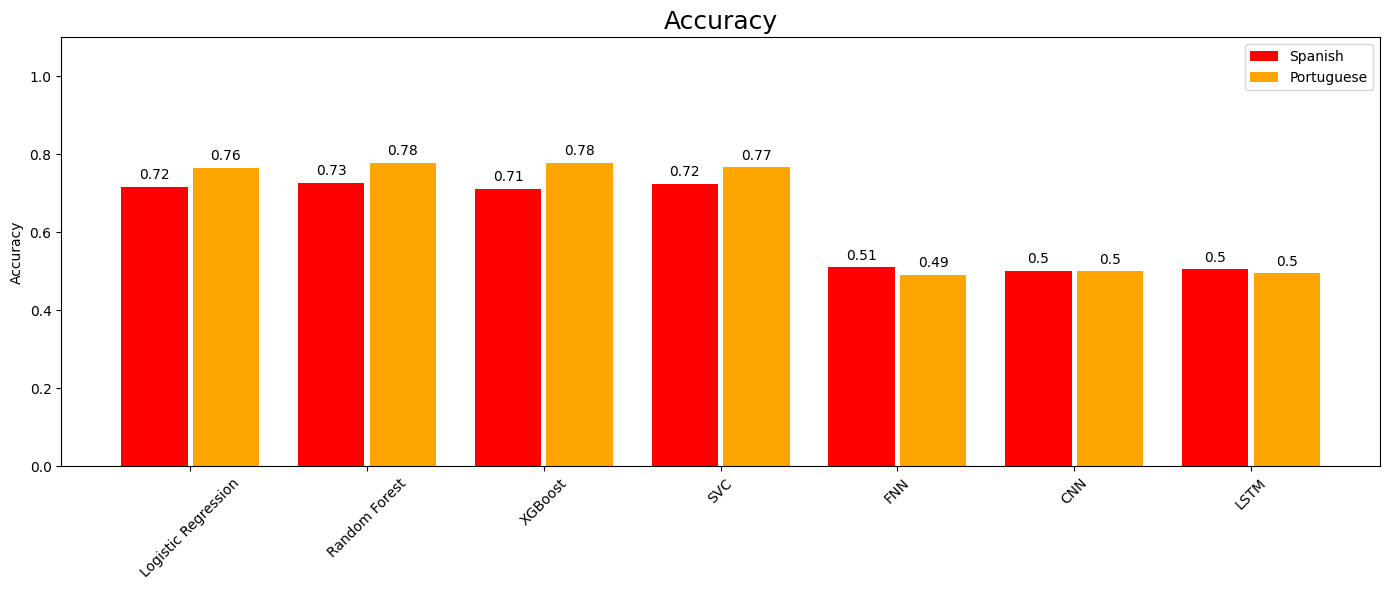

In [14]:
import matplotlib.pyplot as plt

# Define the classification report variables
classification_reports = {
    'Logistic Regression (es)': logistic_regression_spanish_classification_report_,
    'Logistic Regression (pt)': logistic_regression_portuguese_classification_report_,
    'Random Forest (es)': random_forest_spanish_classification_report_,
    'Random Forest (pt)': random_forest_portuguese_classification_report_,
    'XGBoost (es)': xgboost_spanish_classification_report_,
    'XGBoost (pt)': xgboost_forest_portuguese_classification_report_,
    'SVC (es)': svc_spanish_classification_report_,
    'SVC (pt)': svc_forest_portuguese_classification_report_,
    'FNN (es)': fnn_spanish_classification_report_,
    'FNN (pt)': fnn_portuguese_classification_report_,
    'CNN (es)': cnn_spanish_classification_report_,
    'CNN (pt)': cnn_portuguese_classification_report_,
    'LSTM (es)': lstm_spanish_classification_report_,
    'LSTM (pt)': lstm_portuguese_classification_report_
}

# Models list for consistency in plotting
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'SVC', 'FNN', 'CNN', 'LSTM']

# Function to add value labels in the middle of bars
def add_value_labels(ax, bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.03, round(yval, 2), ha='center', va='center', color='black')

# Create a single plot for both Spanish and Portuguese models
fig, ax = plt.subplots(figsize=(14, 6))

# Gap between bars
gap = 0.03

# Adjusted bar width for two bars (precision and recall)
bar_width = 0.375

# Plot accuracy for Spanish and Portuguese models, grouped by model
spanish_accuracies = [classification_reports[f'{model} (es)']['accuracy'] for model in models]
portuguese_accuracies = [classification_reports[f'{model} (pt)']['accuracy'] for model in models]

# Positions of the bars on the x-axis, with a small gap
r1 = [x - (bar_width/2 + gap/2) for x in range(len(models))]
r2 = [x + (bar_width/2 + gap/2) for x in range(len(models))]

# Creating the bars for Spanish and Portuguese
bars1 = ax.bar(r1, spanish_accuracies, width=bar_width, color='red', label='Spanish')
bars2 = ax.bar(r2, portuguese_accuracies, width=bar_width, color='orange', label='Portuguese')

# Set plot title and labels
ax.set_title('Accuracy', size=18)
ax.set_ylim(0, 1.1)
ax.set_ylabel('Accuracy')
ax.set_xticks(range(len(models)))
ax.set_xticklabels(models, rotation=45)
add_value_labels(ax, bars1)
add_value_labels(ax, bars2)
ax.legend()

plt.tight_layout()
plt.savefig('../Images/spanish_portuguese_models_accuracies.png', dpi=600, bbox_inches='tight')
plt.show()

### Precision & recall

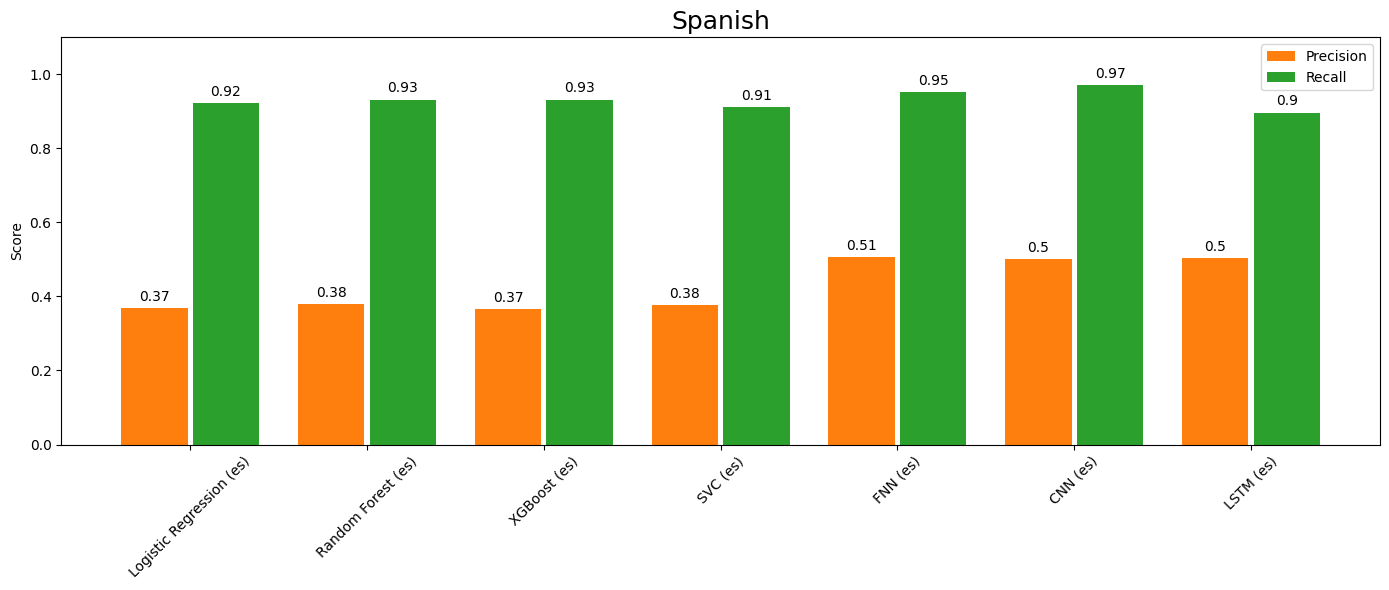

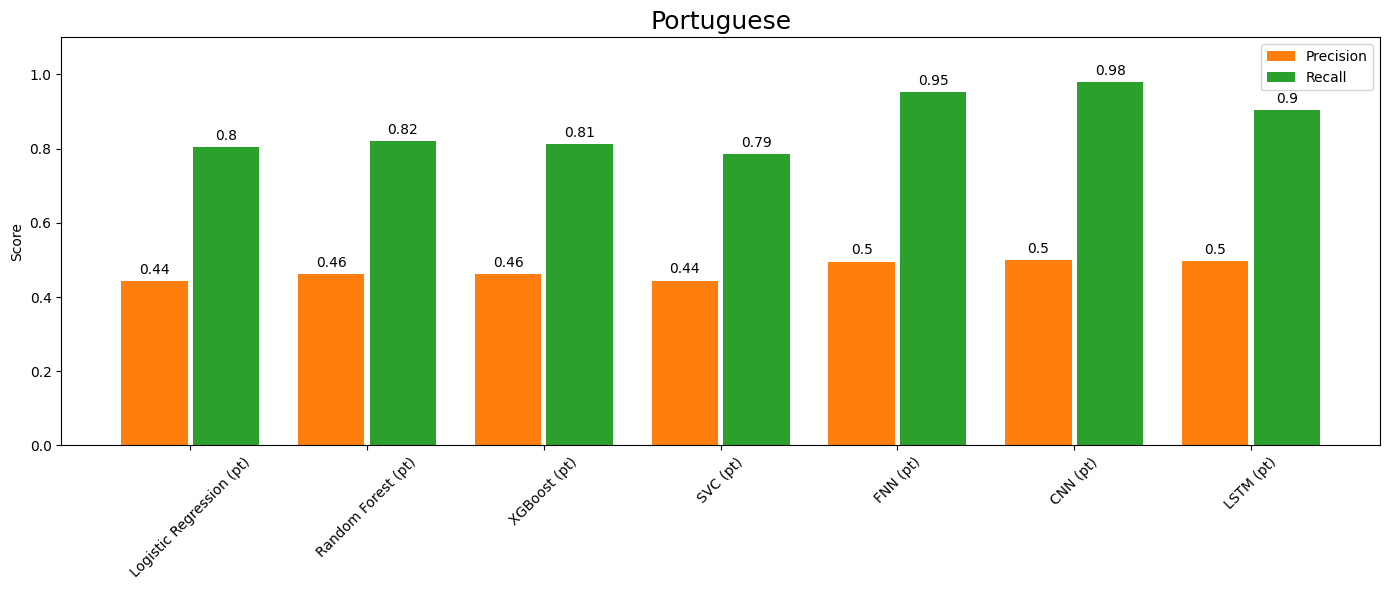

In [15]:
# Lists to separate models by language
spanish_models = ['Logistic Regression (es)', 'Random Forest (es)', 'XGBoost (es)', 'SVC (es)', 'FNN (es)', 'CNN (es)', 'LSTM (es)']
portuguese_models = ['Logistic Regression (pt)', 'Random Forest (pt)', 'XGBoost (pt)', 'SVC (pt)', 'FNN (pt)', 'CNN (pt)', 'LSTM (pt)']

# Function to add value labels in the middle of bars
def add_value_labels(ax, bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.03, round(yval, 2), ha='center', va='center', color='black')

# Gap between bars
gap = 0.03

# Adjusted bar width for two bars (precision and recall)
bar_width = 0.375

# Create a single plot for Spanish models
fig, ax = plt.subplots(figsize=(14, 5))

# Plot precision and recall for Spanish models
spanish_precisions = [classification_reports[model]['1']['precision'] for model in spanish_models]
spanish_recalls = [classification_reports[model]['1']['recall'] for model in spanish_models]

# Adjust the bar positions to ensure correct spacing
r1 = [i - (bar_width/2 + gap/2) for i in range(len(spanish_models))]
r2 = [i + (bar_width/2 + gap/2) for i in range(len(spanish_models))]

bars1 = ax.bar(r1, spanish_precisions, width=bar_width, color='tab:orange', label='Precision')
bars2 = ax.bar(r2, spanish_recalls, width=bar_width, color='tab:green', label='Recall')

ax.set_title('Spanish', size=18)
ax.set_ylim(0, 1.1)
ax.set_ylabel('Score')
ax.set_xticks(range(len(spanish_models)))
ax.set_xticklabels(spanish_models, rotation=45)
add_value_labels(ax, bars1)
add_value_labels(ax, bars2)
ax.legend()

plt.tight_layout()
plt.savefig('../Images/spanish_models_performance_precision_recall.png', dpi=600, bbox_inches='tight')
plt.show()

# Create a single plot for Portuguese models
fig, ax = plt.subplots(figsize=(14, 5))

# Plot precision and recall for Portuguese models
portuguese_precisions = [classification_reports[model]['1']['precision'] for model in portuguese_models]
portuguese_recalls = [classification_reports[model]['1']['recall'] for model in portuguese_models]

# Adjust the bar positions to ensure correct spacing
r1 = [i - (bar_width/2 + gap/2) for i in range(len(portuguese_models))]
r2 = [i + (bar_width/2 + gap/2) for i in range(len(portuguese_models))]

bars1 = ax.bar(r1, portuguese_precisions, width=bar_width, color='tab:orange', label='Precision')
bars2 = ax.bar(r2, portuguese_recalls, width=bar_width, color='tab:green', label='Recall')

ax.set_title('Portuguese', size=18)
ax.set_ylim(0, 1.1)
ax.set_ylabel('Score')
ax.set_xticks(range(len(portuguese_models)))
ax.set_xticklabels(portuguese_models, rotation=45)
add_value_labels(ax, bars1)
add_value_labels(ax, bars2)
ax.legend()

plt.tight_layout()
plt.savefig('../Images/portuguese_models_performance_precision_recall.png', dpi=600, bbox_inches='tight')
plt.show()

### Training vs. validation gap

There is a large gap between training and validation accuracy for the neural network models, suggesting overfitting.

In [16]:
# model abreviations
models = ['FNN', 'CNN', 'LSTM']


# spanish report
training_accuracies = [round(fnn_spanish_history.history['accuracy'][-1], 2),
                       round(cnn_spanish_history.history['accuracy'][-1], 2),
                       round(lstm_spanish_history.history['accuracy'][-1], 2)]
validation_accuracies = [round(fnn_spanish_history.history['val_accuracy'][-1], 2),
                         round(cnn_spanish_history.history['val_accuracy'][-1], 2),
                         round(lstm_spanish_history.history['val_accuracy'][-1], 2)]

report = "Spanish:\n\n"
report += "Model      Training acc.        Validation acc.\n"
report += "-" * 50 + "\n"

for model, train_acc, val_acc in zip(models, training_accuracies, validation_accuracies):
    report += f"{model:<10} {train_acc:<20} {val_acc:<20}\n"

print(report)
print()


# portuguese report
training_accuracies = [round(fnn_portuguese_history.history['accuracy'][-1], 2),
                       round(cnn_portuguese_history.history['accuracy'][-1], 2),
                       round(lstm_portuguese_history.history['accuracy'][-1], 2)]
validation_accuracies = [round(fnn_portuguese_history.history['val_accuracy'][-1], 2),
                         round(cnn_portuguese_history.history['val_accuracy'][-1], 2),
                         round(lstm_portuguese_history.history['val_accuracy'][-1], 2)]

report = "Portuguese:\n\n"
report += "Model      Training acc.        Validation acc.\n"
report += "-" * 50 + "\n"

for model, train_acc, val_acc in zip(models, training_accuracies, validation_accuracies):
    report += f"{model:<10} {train_acc:<20} {val_acc:<20}\n"

print(report)
print()

Spanish:

Model      Training acc.        Validation acc.
--------------------------------------------------
FNN        0.98                 0.29                
CNN        1.0                  0.25                
LSTM       1.0                  0.31                


Portuguese:

Model      Training acc.        Validation acc.
--------------------------------------------------
FNN        0.95                 0.19                
CNN        1.0                  0.18                
LSTM       1.0                  0.29                


